# Wstęp do przetwarzania języka naturalnego

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

### Średniowieczne podejścia - bag of words

In [4]:
from bs4 import BeautifulSoup
import re

In [5]:
reviews = pd.read_csv("http://galera.ii.pw.edu.pl/~kdeja/data/sst2.tsv",delimiter="\t",quoting=3).reset_index(drop=True)

In [6]:
reviews

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
67344,a delightful comedy,1
67345,"anguish , anger and frustration",0
67346,"at achieving the modest , crowd-pleasing goals...",1
67347,a patient viewer,1


In [7]:
print(reviews["sentence"][4])

on the worst revenge-of-the-nerds clichés the filmmakers could dredge up 


In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/kieru/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def review_to_words(raw_review):
    """Function to convert a review to a string of words.
    The input is a single string (a raw movie review), and the output is a single string (a preprocessed movie review)"""
    review_text = BeautifulSoup(raw_review, 'lxml').get_text()
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_words = [word for word in words if not word in stops]
    return " ".join(meaningful_words)

In [11]:
clean_review = review_to_words(reviews['sentence'][4])
print(clean_review)

worst revenge nerds clich filmmakers could dredge


In [12]:
num_reviews = reviews['sentence'].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length of the move review list
for review in range(0, num_reviews):
    # If the index is evenly divisible by 100, print a message
    if (review+1) % 1000 == 0:
        print('Review {} of {}'.format(review+1, num_reviews))
    # Call our function for each one, and add the result to the list of clean reviews
    clean_train_reviews.append(review_to_words(reviews['sentence'][review]))

/tmp/ipykernel_28228/3593606712.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'lxml').get_text()


Review 1000 of 67349
Review 2000 of 67349
Review 3000 of 67349
Review 4000 of 67349
Review 5000 of 67349
Review 6000 of 67349
Review 7000 of 67349
Review 8000 of 67349
Review 9000 of 67349
Review 10000 of 67349
Review 11000 of 67349
Review 12000 of 67349
Review 13000 of 67349
Review 14000 of 67349
Review 15000 of 67349
Review 16000 of 67349
Review 17000 of 67349
Review 18000 of 67349
Review 19000 of 67349
Review 20000 of 67349
Review 21000 of 67349
Review 22000 of 67349
Review 23000 of 67349
Review 24000 of 67349
Review 25000 of 67349
Review 26000 of 67349
Review 27000 of 67349
Review 28000 of 67349
Review 29000 of 67349
Review 30000 of 67349
Review 31000 of 67349
Review 32000 of 67349
Review 33000 of 67349
Review 34000 of 67349
Review 35000 of 67349
Review 36000 of 67349
Review 37000 of 67349
Review 38000 of 67349
Review 39000 of 67349
Review 40000 of 67349
Review 41000 of 67349
Review 42000 of 67349
Review 43000 of 67349
Review 44000 of 67349
Review 45000 of 67349
Review 46000 of 673

In [13]:
print('Creating the bag of words...')
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
vectorizer = CountVectorizer(analyzer = 'word',
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = None,
                            max_features = 1000)
# fit_transform() does two functions: First, it fits the model
# and learns the vocaulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an array
train_data_features = train_data_features.toarray()
print('Bag of words completed')

Creating the bag of words...
Bag of words completed


In [14]:
vocab = vectorizer.get_feature_names_out()
print(len(vocab))

1000


In [15]:
train_indices = np.random.rand(len(reviews))>0.3
train_data = torch.from_numpy(train_data_features).float()[train_indices]
train_targets = torch.from_numpy(reviews["label"].values[train_indices]).long()

test_data = torch.from_numpy(train_data_features[~train_indices]).float()
test_targets = torch.from_numpy(reviews["label"].values[~train_indices]).long()

In [16]:
train_dataset = data.TensorDataset(train_data,train_targets)
test_dataset = data.TensorDataset(test_data,test_targets)

In [17]:
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [18]:
class BoWClassifier(nn.Module):
    def __init__(self): 
        super(BoWClassifier, self).__init__()
        self.lin1 =nn.Linear(1000, 500)
        self.act1 =nn.LeakyReLU()
        self.lin2 =nn.Linear(500, 50)
        self.act2 =nn.LeakyReLU()
        self.lin3 =nn.Linear(50, 2)
        
             
    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x
bow_model = BoWClassifier().to(device)
bow_model

BoWClassifier(
  (lin1): Linear(in_features=1000, out_features=500, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (lin2): Linear(in_features=500, out_features=50, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (lin3): Linear(in_features=50, out_features=2, bias=True)
)

In [19]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, labels in iter(train_loader):
        x, labels = x.to(device), labels.to(device)
        bow_model.train() 
        out = bow_model(x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(bow_model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(bow_model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 0.483 test_acc: 0.773
Epoch 1 loss 0.385 test_acc: 0.8
Epoch 2 loss 0.322 test_acc: 0.809
Epoch 3 loss 0.288 test_acc: 0.812
Epoch 4 loss 0.268 test_acc: 0.812
Epoch 5 loss 0.258 test_acc: 0.813
Epoch 6 loss 0.25 test_acc: 0.812
Epoch 7 loss 0.246 test_acc: 0.814
Epoch 8 loss 0.241 test_acc: 0.813
Epoch 9 loss 0.238 test_acc: 0.814
Final Training Accuracy: 0.868309620596206
Final Validation Accuracy: 0.8138205319413373


In [21]:
example_1_text = "I do not like this movie"
example_2_text = "I like this movie"
examples = vectorizer.transform([review_to_words(example_1_text),review_to_words(example_2_text)])
examples = torch.from_numpy(examples.toarray()).to(device).float()
bow_model(examples)

tensor([[-0.6111,  0.5300],
        [-0.6111,  0.5300]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
example_1_text = "The topic of this movie is love"
example_2_text = "I love a movie about this topic"
examples = vectorizer.transform([review_to_words(example_1_text),review_to_words(example_2_text)])
examples = torch.from_numpy(examples.toarray()).to(device).float()
bow_model(examples)

tensor([[-2.7634,  2.7561],
        [-2.7634,  2.7561]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Embeddingi w języku

In [24]:
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
corpus = api.load('text8')
gensim_model = Word2Vec(corpus)

[==================================================] 100.0% 31.6/31.6MB downloaded


In [25]:
gensim_model.wv["king"]

array([ 0.13339266,  1.8876835 ,  2.6700191 , -0.69340384, -0.7490411 ,
        1.9777726 , -0.52956545,  0.21457991,  1.6818674 ,  1.6169816 ,
       -0.59351724, -0.54133415,  1.0678469 ,  3.6284897 ,  1.0552745 ,
        0.14805715,  0.8235456 ,  2.1659665 , -0.48115572,  0.86099964,
        0.6009968 , -0.15306573, -3.0095167 ,  0.6101597 , -2.3038478 ,
        2.238226  ,  0.21856068,  3.4827077 ,  0.20567325, -0.6870403 ,
       -0.18241686,  0.24984659, -0.7523722 ,  0.6705854 ,  1.4565288 ,
        1.2905627 ,  0.08430897, -1.2670574 , -0.83090323, -1.1133698 ,
       -0.38357988,  0.10765132,  0.13472192,  1.1420494 , -2.2820685 ,
       -1.5219623 , -0.10362937, -1.2837416 ,  1.2411294 , -2.3586779 ,
        1.833984  ,  1.2108414 , -2.5602224 ,  0.6886402 , -0.21302383,
       -2.256714  ,  0.4328529 ,  2.635398  ,  0.22774096, -0.4935491 ,
        1.8264734 , -2.0130975 ,  1.5820124 , -0.20700753, -1.0227681 ,
       -2.5852447 , -0.41122225,  1.4872781 ,  2.6085248 , -1.77

In [26]:
gensim_model.wv.most_similar("king")

[('prince', 0.7349629402160645),
 ('throne', 0.7205792665481567),
 ('emperor', 0.7142632603645325),
 ('queen', 0.7050169706344604),
 ('kings', 0.7006803750991821),
 ('elector', 0.6772159934043884),
 ('aragon', 0.6701691746711731),
 ('vii', 0.6656975746154785),
 ('sultan', 0.6617438793182373),
 ('iii', 0.6609362363815308)]

In [27]:
gensim_model.wv.most_similar("car")

[('driver', 0.8174227476119995),
 ('motorcycle', 0.7254319787025452),
 ('cars', 0.7222384214401245),
 ('taxi', 0.7152960896492004),
 ('vehicle', 0.7065077424049377),
 ('truck', 0.6793736219406128),
 ('racing', 0.6472298502922058),
 ('automobile', 0.6344322562217712),
 ('passenger', 0.6342279314994812),
 ('audi', 0.6327622532844543)]

In [28]:
gensim_model.wv.most_similar("love")

[('loving', 0.6977720260620117),
 ('passion', 0.6435652375221252),
 ('me', 0.6402586102485657),
 ('affection', 0.6308778524398804),
 ('soul', 0.6307668089866638),
 ('thee', 0.626196563243866),
 ('my', 0.6122002005577087),
 ('dreams', 0.606260359287262),
 ('praise', 0.6008821129798889),
 ('grace', 0.5964429378509521)]

## Jak trenować embeddingi 

In [29]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.3320,  2.3638,  0.8769,  0.1382, -0.3959]],
       grad_fn=<EmbeddingBackward0>)


#### Czyli wklejamy warstwę nn.Embedding uczymy tak jak powyżej i już?

## Continuous Bag-of-Words - przewidywanie słowa na podstawie kontekstu

In [30]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
test_sentence = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".lower().split()

ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)] + [test_sentence[i + j + 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence)-CONTEXT_SIZE)
]
# Print the first 3, just so you can see what they look like.
print(test_sentence[:20])
print(ngrams[:3])

['we', 'are', 'about', 'to', 'study', 'the', 'idea', 'of', 'a', 'computational', 'process.', 'computational', 'processes', 'are', 'abstract', 'beings', 'that', 'inhabit', 'computers.', 'as']
[(['are', 'we', 'to', 'study'], 'about'), (['about', 'are', 'study', 'the'], 'to'), (['to', 'about', 'the', 'idea'], 'study')]


In [31]:
vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [32]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(2 * context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [33]:
losses = []
loss_function = nn.NLLLoss()
emb_model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.Adam(emb_model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:

        # Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        emb_model.zero_grad()
        log_probs = emb_model(context_idxs)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(total_loss)
    losses.append(total_loss)

227.12177300453186
184.04519701004028
145.4041930437088
104.8639067709446
67.1034374088049
38.84411363303661
22.226178288459778
13.624894328415394
9.197277262806892
6.719919739291072


In [34]:
print(emb_model.embeddings.weight[word_to_ix["computer"]])

tensor([-0.3811,  1.9330,  0.0371, -0.5038,  1.0477, -2.0677,  1.0553, -1.6230,
        -1.0013,  0.8436], grad_fn=<SelectBackward0>)


In [35]:
print(emb_model.embeddings.weight[word_to_ix["computational"]])

tensor([ 0.2740, -0.3243, -0.1847, -1.0489, -1.1561,  0.5206,  0.9422, -2.1432,
         0.9320, -0.9396], grad_fn=<SelectBackward0>)


In [36]:
with torch.no_grad():
    sim1 = torch.cosine_similarity(emb_model.embeddings.weight[word_to_ix["process"]].unsqueeze(0),emb_model.embeddings.weight[word_to_ix["computational"]].unsqueeze(0))
    sim2 = torch.cosine_similarity(emb_model.embeddings.weight[word_to_ix["process"]].unsqueeze(0),emb_model.embeddings.weight[word_to_ix["study"]].unsqueeze(0))

print(sim1)
print(sim2)

tensor([0.1672])
tensor([-0.2048])


In [37]:
print(emb_model.embeddings.weight[word_to_ix["Śpiulkolot"]])

KeyError: 'Śpiulkolot'

In [38]:
emb_model.embeddings.weight.size()

torch.Size([46, 10])

## Mini zadanie - zaimplementuj skip-gram - w odwrotną stronę
Przewidujmy kontekst w oparciu o jedno słowo

# Pytanie: jak duży musi być model dla prawdziwego słownika?

# Rozwiązywanie problemów z wykorzystaniem embeddingów

In [39]:
emb_weights = torch.FloatTensor(gensim_model.wv.vectors)

In [40]:
emb_weights.size()

torch.Size([71290, 100])

In [41]:
embedding = nn.Embedding.from_pretrained(emb_weights)
embedding.requires_grad = False

In [42]:
tokenizer = gensim_model.wv.key_to_index

In [43]:
clean_train_reviews_tokenized = []
for review in reviews['sentence']:
    unknows = 0
    all_parsed = 0
    review_tokenized = []
    for word in review.split():
        all_parsed+=1
        try:
            review_tokenized.append(tokenizer[word.lower()])
        except:
            unknows +=1
#     print(unknows/all_parsed)
    clean_train_reviews_tokenized.append(review_tokenized)

In [44]:
class ReviewDataset(Dataset):
    def __init__(self, data,labels):
        self.data = []
        for d, l in zip(data,labels):
            self.data.append((torch.from_numpy(np.array(d)).long(),torch.tensor(l).long()))
            

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [45]:
train_data = ReviewDataset(np.array(clean_train_reviews_tokenized, dtype=object)[train_indices],reviews["label"].values[train_indices])
test_data = ReviewDataset(np.array(clean_train_reviews_tokenized, dtype=object)[~train_indices],reviews["label"].values[~train_indices])

In [46]:
from torch.nn.utils.rnn import pad_sequence
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x)-1 for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy = torch.stack(yy)
    return xx_pad, yy, x_lens

In [47]:
train_loader = DataLoader(train_data, batch_size=32, collate_fn=pad_collate, shuffle=True,drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=pad_collate, shuffle=False)

In [48]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, emb_weights, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, batch_first=False)
        self.fc = nn.Linear(hidden_size*self.bidirectional, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, len_x, hidden):
        x = self.embeddings(x)
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        last_seq_items = all_outputs[range(all_outputs.shape[0]), len_x]
        out = last_seq_items # torch.flatten(all_outputs,1)
        x = self.fc(out)
        return x, hidden
     
lstm_model = LSTMRegressor(100, 100, 1, 2, emb_weights).to(device)
lstm_model

LSTMRegressor(
  (embeddings): Embedding(71290, 100)
  (lstm): LSTM(100, 100)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [49]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 0.001)
loss_fun = nn.CrossEntropyLoss()
lstm_model.train()

# Training loop
for epoch in range(31):
    losses = 0
    batches = 0
    for x, targets, len_x in train_loader:
        x = x.to(device)
        targets = targets.to(device)
        hidden, state = lstm_model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, _ = lstm_model(x, len_x, (hidden,state))
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        batches +=1
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {losses/batches:.3}")

Epoch: 0, loss: 0.551
Epoch: 10, loss: 0.145
Epoch: 20, loss: 0.1
Epoch: 30, loss: 0.0816


In [50]:
# lstm_model.load_state_dict(torch.load("lab_13/lstm_model_dict"))

In [51]:
lstm_model.eval()
with torch.no_grad():
    preds_list = []
    targets_list = []
    for x, targets, len_x in test_loader:
        x = x.to(device)
        targets_list.append(targets.numpy())
        targets = targets.to(device)
        hidden, state = lstm_model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, _ = lstm_model(x, len_x, (hidden,state))
        preds = preds.squeeze(1)
        preds_list.append(preds.cpu().numpy())

In [52]:
print(f"Test accuracy: {(np.argmax((np.concatenate(preds_list)),1) == np.concatenate(targets_list)).sum()/len(np.concatenate(targets_list)):.3}")

Test accuracy: 0.864


In [54]:
torch.save(lstm_model.state_dict(),"models/lab13/lstm_model_dict")

In [55]:
example_1_text = "I do not like this movie"
example_2_text = "I like this movie"
example_1_tokenized = []
for word in example_1_text.split():
    try:
        example_1_tokenized.append(tokenizer[word])
    except:
        continue
example_2_tokenized = []
for word in example_2_text.split():
    try:
        example_2_tokenized.append(tokenizer[word])
    except:
        continue
hidden, state = lstm_model.init_hidden(1)
hidden, state = hidden.to(device), state.to(device) 
preds_1,_ = lstm_model(torch.from_numpy(np.array(example_1_tokenized)).unsqueeze(0).to(device),len(example_1_tokenized)-1,(hidden,state))
preds_2,_ = lstm_model(torch.from_numpy(np.array(example_2_tokenized)).unsqueeze(0).to(device),len(example_2_tokenized)-1,(hidden,state))

In [56]:
print(preds_1)
print(preds_2)

tensor([[ 2.3498, -2.4868]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-3.6944,  3.5719]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Arytmetyka na embeddingach

In [57]:
gensim_model.wv["car"]

array([ 0.20327657, -1.3371632 , -0.07425798,  0.73433286,  0.19710861,
       -1.842164  , -1.6896536 ,  0.17760849,  2.1416192 ,  0.7001407 ,
        0.39594802, -0.82978904,  1.0343374 ,  1.0447704 , -3.1818388 ,
       -0.8613659 ,  2.2369003 , -1.5386881 ,  1.4481099 ,  0.5350605 ,
        0.26765957,  1.0254495 ,  1.8813043 , -1.7352856 , -0.29233915,
       -0.06325834, -0.06359205,  1.6479425 ,  0.03436931, -0.17052107,
        0.24371852,  1.1445707 , -1.0282207 ,  1.4140178 , -2.5645301 ,
       -0.8802483 , -0.7278783 , -2.7516909 , -1.391205  ,  0.55734885,
        1.1868563 , -1.7004931 ,  0.97156334,  1.098507  ,  1.5320588 ,
       -1.1591041 , -3.4128082 , -1.0134617 ,  1.2334167 , -0.3653265 ,
       -0.05805945, -0.15668347,  2.1329446 , -2.25584   ,  1.203608  ,
        2.4360988 , -0.5210286 , -1.3407598 ,  0.32769048, -0.17024717,
       -0.7347759 , -0.12568958,  0.03310317, -0.00600551, -1.36539   ,
       -0.32284328, -0.8544755 , -0.1406682 , -2.33968   , -1.64

In [58]:
tokenizer["car"]

982

In [59]:
emb_weights[tokenizer["car"]]

tensor([ 0.2033, -1.3372, -0.0743,  0.7343,  0.1971, -1.8422, -1.6897,  0.1776,
         2.1416,  0.7001,  0.3959, -0.8298,  1.0343,  1.0448, -3.1818, -0.8614,
         2.2369, -1.5387,  1.4481,  0.5351,  0.2677,  1.0254,  1.8813, -1.7353,
        -0.2923, -0.0633, -0.0636,  1.6479,  0.0344, -0.1705,  0.2437,  1.1446,
        -1.0282,  1.4140, -2.5645, -0.8802, -0.7279, -2.7517, -1.3912,  0.5573,
         1.1869, -1.7005,  0.9716,  1.0985,  1.5321, -1.1591, -3.4128, -1.0135,
         1.2334, -0.3653, -0.0581, -0.1567,  2.1329, -2.2558,  1.2036,  2.4361,
        -0.5210, -1.3408,  0.3277, -0.1702, -0.7348, -0.1257,  0.0331, -0.0060,
        -1.3654, -0.3228, -0.8545, -0.1407, -2.3397, -1.6461,  2.7521,  1.3341,
        -0.6927,  1.6357, -0.1431,  0.9722,  0.0233,  1.8829, -0.9044, -0.5650,
        -1.1086, -1.6391,  0.5183,  2.7137, -1.0750, -1.3917,  0.7145, -0.5148,
         1.6151,  0.8379,  0.8271, -0.6378, -3.6859, -0.9348,  0.7292, -1.6772,
         1.7024, -0.2982,  1.4439,  1.09

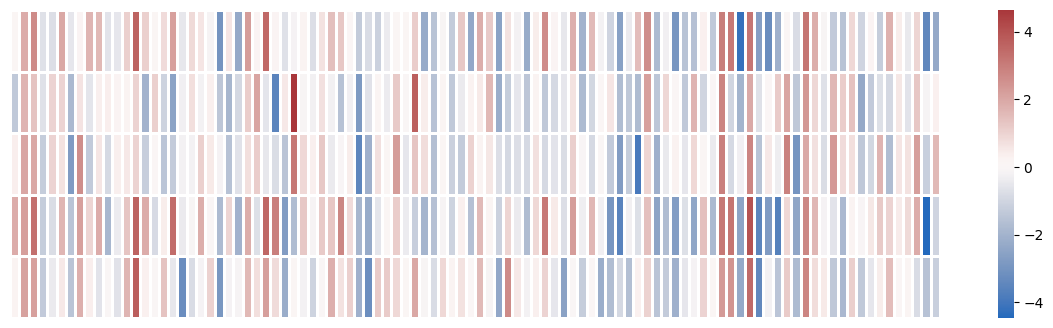

In [60]:
plt.figure(figsize=(15,4))
sns.heatmap([gensim_model.wv["king"], 
             gensim_model.wv["man"], 
             gensim_model.wv["woman"], 
             gensim_model.wv["king"] - gensim_model.wv["man"] + gensim_model.wv["woman"],
             gensim_model.wv["queen"],
            ], cbar=True, xticklabels=False, yticklabels=False,linewidths=1,cmap="vlag") 
plt.show()

In [61]:
x = gensim_model.wv["paris"] + gensim_model.wv["germany"] - gensim_model.wv["berlin"]

In [62]:
x

array([-1.6626449 , -0.31117308,  0.20915104, -0.7257631 ,  0.6381916 ,
        1.7852855 , -3.39412   ,  4.004383  ,  1.9058394 ,  1.7104747 ,
       -0.92319447, -1.7824296 , -0.9651712 ,  0.9087151 , -0.54452527,
       -1.052601  , -1.8190565 , -2.6259663 , -0.8138212 ,  0.26190984,
        0.13987489,  1.5264757 , -1.135104  ,  0.5918043 ,  0.28018445,
        1.9295578 , -0.66119754,  0.95267045, -0.23843634,  0.6051739 ,
       -2.2989872 , -0.38280356, -0.3500054 ,  2.1507523 , -1.6565998 ,
        2.7201958 ,  1.4916588 , -4.222001  , -0.58255756, -1.027005  ,
       -0.07382348,  0.4174245 , -1.9609661 ,  0.5525418 , -1.624783  ,
        0.8132373 , -0.6735233 ,  0.3410684 , -1.1790097 , -2.1663675 ,
        1.7396708 ,  3.1968186 ,  0.5951371 ,  1.5035024 ,  3.1089654 ,
        0.96239066,  0.8791715 ,  1.3467505 , -0.29088092,  1.2826053 ,
        0.34221882, -0.38619182, -0.16236794, -0.19734773, -1.0167805 ,
       -2.787023  ,  2.2104473 ,  1.5850219 ,  1.4624876 ,  0.37

In [63]:
gensim_model.wv["france"]

array([-0.9813531 ,  0.82840466,  0.821929  , -2.144536  ,  0.32480264,
        2.5483463 , -0.8243572 ,  3.6620412 ,  0.9843587 ,  1.137295  ,
        0.6883987 , -0.3339095 , -1.2547622 ,  0.41545793, -0.3020925 ,
        0.0474313 , -1.199551  , -0.23994805, -1.0854532 , -0.6821749 ,
       -0.05693669,  1.499424  , -2.0554476 ,  1.5389916 , -0.383668  ,
        2.3863466 , -0.8027859 ,  2.1822736 ,  0.11701371, -0.8220057 ,
       -1.2965312 , -1.1488305 ,  0.7601222 ,  1.455611  , -0.8209637 ,
        0.57556015,  0.72745115, -2.8554003 , -0.62800545, -0.03839626,
        0.1121708 , -0.17735457, -1.0071102 ,  0.97862536, -0.7834279 ,
        2.238006  ,  0.34443474, -0.74529994, -1.2783973 , -1.787315  ,
        1.9288611 ,  2.48244   ,  0.2469941 ,  0.84175223,  2.6366007 ,
        0.3842469 ,  0.40320766,  1.0027941 ,  1.1973574 ,  0.6309989 ,
       -0.38348216, -0.7503607 ,  0.45243138, -1.0583626 , -0.19227935,
       -1.6162837 ,  2.2798598 ,  1.8604559 ,  0.32648   , -0.66

## Mini zadanie: Jak możemy znaleźć do czego odnosi się wektor x?